In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.sparse.linalg import eigsh, expm_multiply, expm

### Correlator generalized for L sites

In [3]:
def gen_spin_operators(L):
    """Returns the spin-1/2 operators sigma_x and sigma_z for L sites."""
    X = sparse.csr_array(np.array([[0.,1.],[1.,0.]]))
    Z = sparse.csr_array(np.diag([1.,-1.]))
    
    d = 2
    Sx_list = []
    Sz_list = []
    
    for i_site in range(L):
        # ops on first site
        if i_site == 0: 
            Sx = X
            Sz = Z 
        else: 
            Sx = sparse.csr_array(np.eye(d))
            Sz = sparse.csr_array(np.eye(d))
        # ops on remaining sites
        for j_site in range(1, L):
            if j_site == i_site: 
                Sx = sparse.kron(Sx, X, 'csr')
                Sz = sparse.kron(Sz, Z, 'csr')
            else:
                Sx = sparse.kron(Sx, np.eye(d), 'csr')
                Sz = sparse.kron(Sz, np.eye(d), 'csr')
        Sx_list.append(Sx)
        Sz_list.append(Sz)
    
    return Sx_list, Sz_list

def gen_hamiltonian_terms(L, Sx_list, Sz_list):
    """Generates the XX and Z terms of the Hamiltonian."""
    D = Sx_list[0].shape[0]
    print(f'System with {L:d} sites, Hilbert space dimension is {D:d}.')

    # Ising interaction
    Hxx = Sx_list[0] @ Sx_list[1]
    for i in range(1, L-1):
        Hxx += Sx_list[i] @ Sx_list[i+1]
    Hxx += Sx_list[L-1] @ Sx_list[0] #PBC
    
    # onsite field terms
    Hz = Sz_list[0]
    for Sz in Sz_list[1:L]:
        Hz += Sz

    
    return Hxx, Hz

In [4]:
# define Hamiltonian terms
L = 11
J = 1.
g = 2.    


Sx_list, Sz_list = gen_spin_operators(L)
Hxx, Hz = gen_hamiltonian_terms(L, Sx_list, Sz_list)

H = -J * Hxx -g * Hz

System with 11 sites, Hilbert space dimension is 2048.


In [5]:
# compute correlator
dt = 1e-2
n = 10
N = 2**n

# get ground state
E, psi = eigsh(H, k=1, which='SA')
E0, psi = np.squeeze(E), np.squeeze(psi)
print('Ground state energy:', E0)
psi_0 = psi.copy()

# put in excitation
psi = Sx_list[L//2] @ psi
E1 = np.dot(psi.conj(), H @ psi).real
print('Excited state energy:', E1)

psil = np.array([Sx_list[l] @ psi_0 for l in range(L)])


# evolve states in time
psis = expm_multiply(-1j * H,
                     psi,
                     start=0,
                     stop=N*dt,
                     num=N,
                     endpoint=False)

# calculate correlators C = <psi| e^iHt X_ell e^-iHt X_L/2 |psi>
Cs = np.einsum('lj, ij -> li', psil.conj(), psis) * np.exp(1j * E0 * np.arange(N) * dt)

Ground state energy: -23.398129065323356
Excited state energy: -19.661535875411232


In [6]:
print(Cs.shape) 
#form is (L,2**n) <-> (X,T)

(11, 1024)


Text(0.5, 1.0, 'correlation function evaluated on 11 sites')

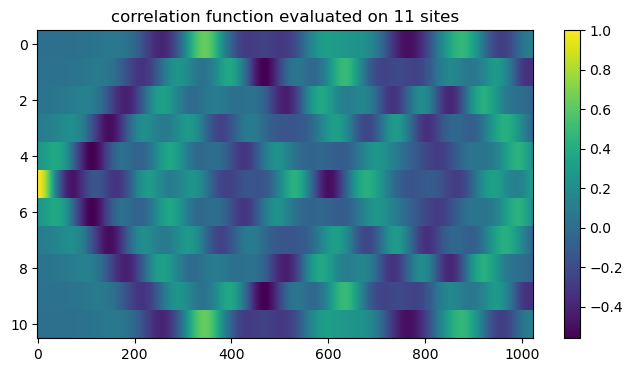

In [7]:
plt.figure(figsize=(8, 4))
plt.imshow(Cs.real, aspect = 'auto', 
           interpolation = 'none'
           )

plt.colorbar()
plt.title("correlation function evaluated on " + f"{L}" + " sites")

In [8]:
import importlib

import TCI_Lsite as TCI
import TCI_Lsite_accumulative as TCI_a

importlib.reload(TCI)
importlib.reload(TCI_a)

ModuleNotFoundError: No module named 'TCI_Lsite'

### Interpolation with TCI

In [ ]:
D = L

func_vals = Cs.T #Cs is in the form (X,T)

#first we define the function f(t)
# which returns the slice of func_vals along x for a specific time 
f_t = lambda *t: Cs.reshape((D,) + (2,) * n)[:,*t]
#here we have to define func as the initialization of the class
func = TCI.function(f_t)

As, _, eval, err_2, err_max, func_interp = TCI.tensor_cross_interpolation(func,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   eps_or_chi=40, # bond dimension
                                   iters=1)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

err_max:  1.81836094561118e-14
err_2:  1.0521577634053995e-14
eval/D:  1024

repeated evaluations:  3940
unique evaluations 1024
unique + repeated:  4964
total evaluations:  4964

34.39628493991049 1.0000000000000033


In [ ]:
importlib.reload(TCI_a)

<module 'TCI_Lsite_accumulative' from '/home/t30/all/go56vod/Desktop/Student-Research-Job/TCI/TCI_Lsite_accumulative.py'>

## Interpolation with accumulative TCI!

In [ ]:
D = L

func_vals = Cs.T #Cs is in the form (X,T)

#first we define the function f(t)
# which returns the slice of func_vals along x for a specific time 
f_t = lambda *t: Cs.reshape((D,) + (2,) * n)[:,*t]
#here we have to define func as the initialization of the class
func_acc = TCI_a.function(f_t)

As, _, eval, err_2, err_max, func_interp = TCI_a.accumulative_tensor_cross_interpolation(func_acc,         # function to be interpolated
                                   func_vals,    
                                   D,
                                   L=n,          # number of MPS tensors
                                   iters=10)       # number of back-and-forth sweeps

print(np.linalg.norm(func_vals), np.max(np.abs(func_vals)))

(1, 2, 1, 11)
(1, 2, 1)
(1, 2, 1)
err_max:  129.08431063088062
err_2:  29.133918573299635
eval/D:  704

repeated evaluations:  16644
unique evaluations 704
unique + repeated:  17348
total evaluations:  17348

34.39628493991049 1.0000000000000033
